In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from library.DIY import *
from tqdm import tqdm

# Grayscale image reduction comparison

creating image object
reducing image


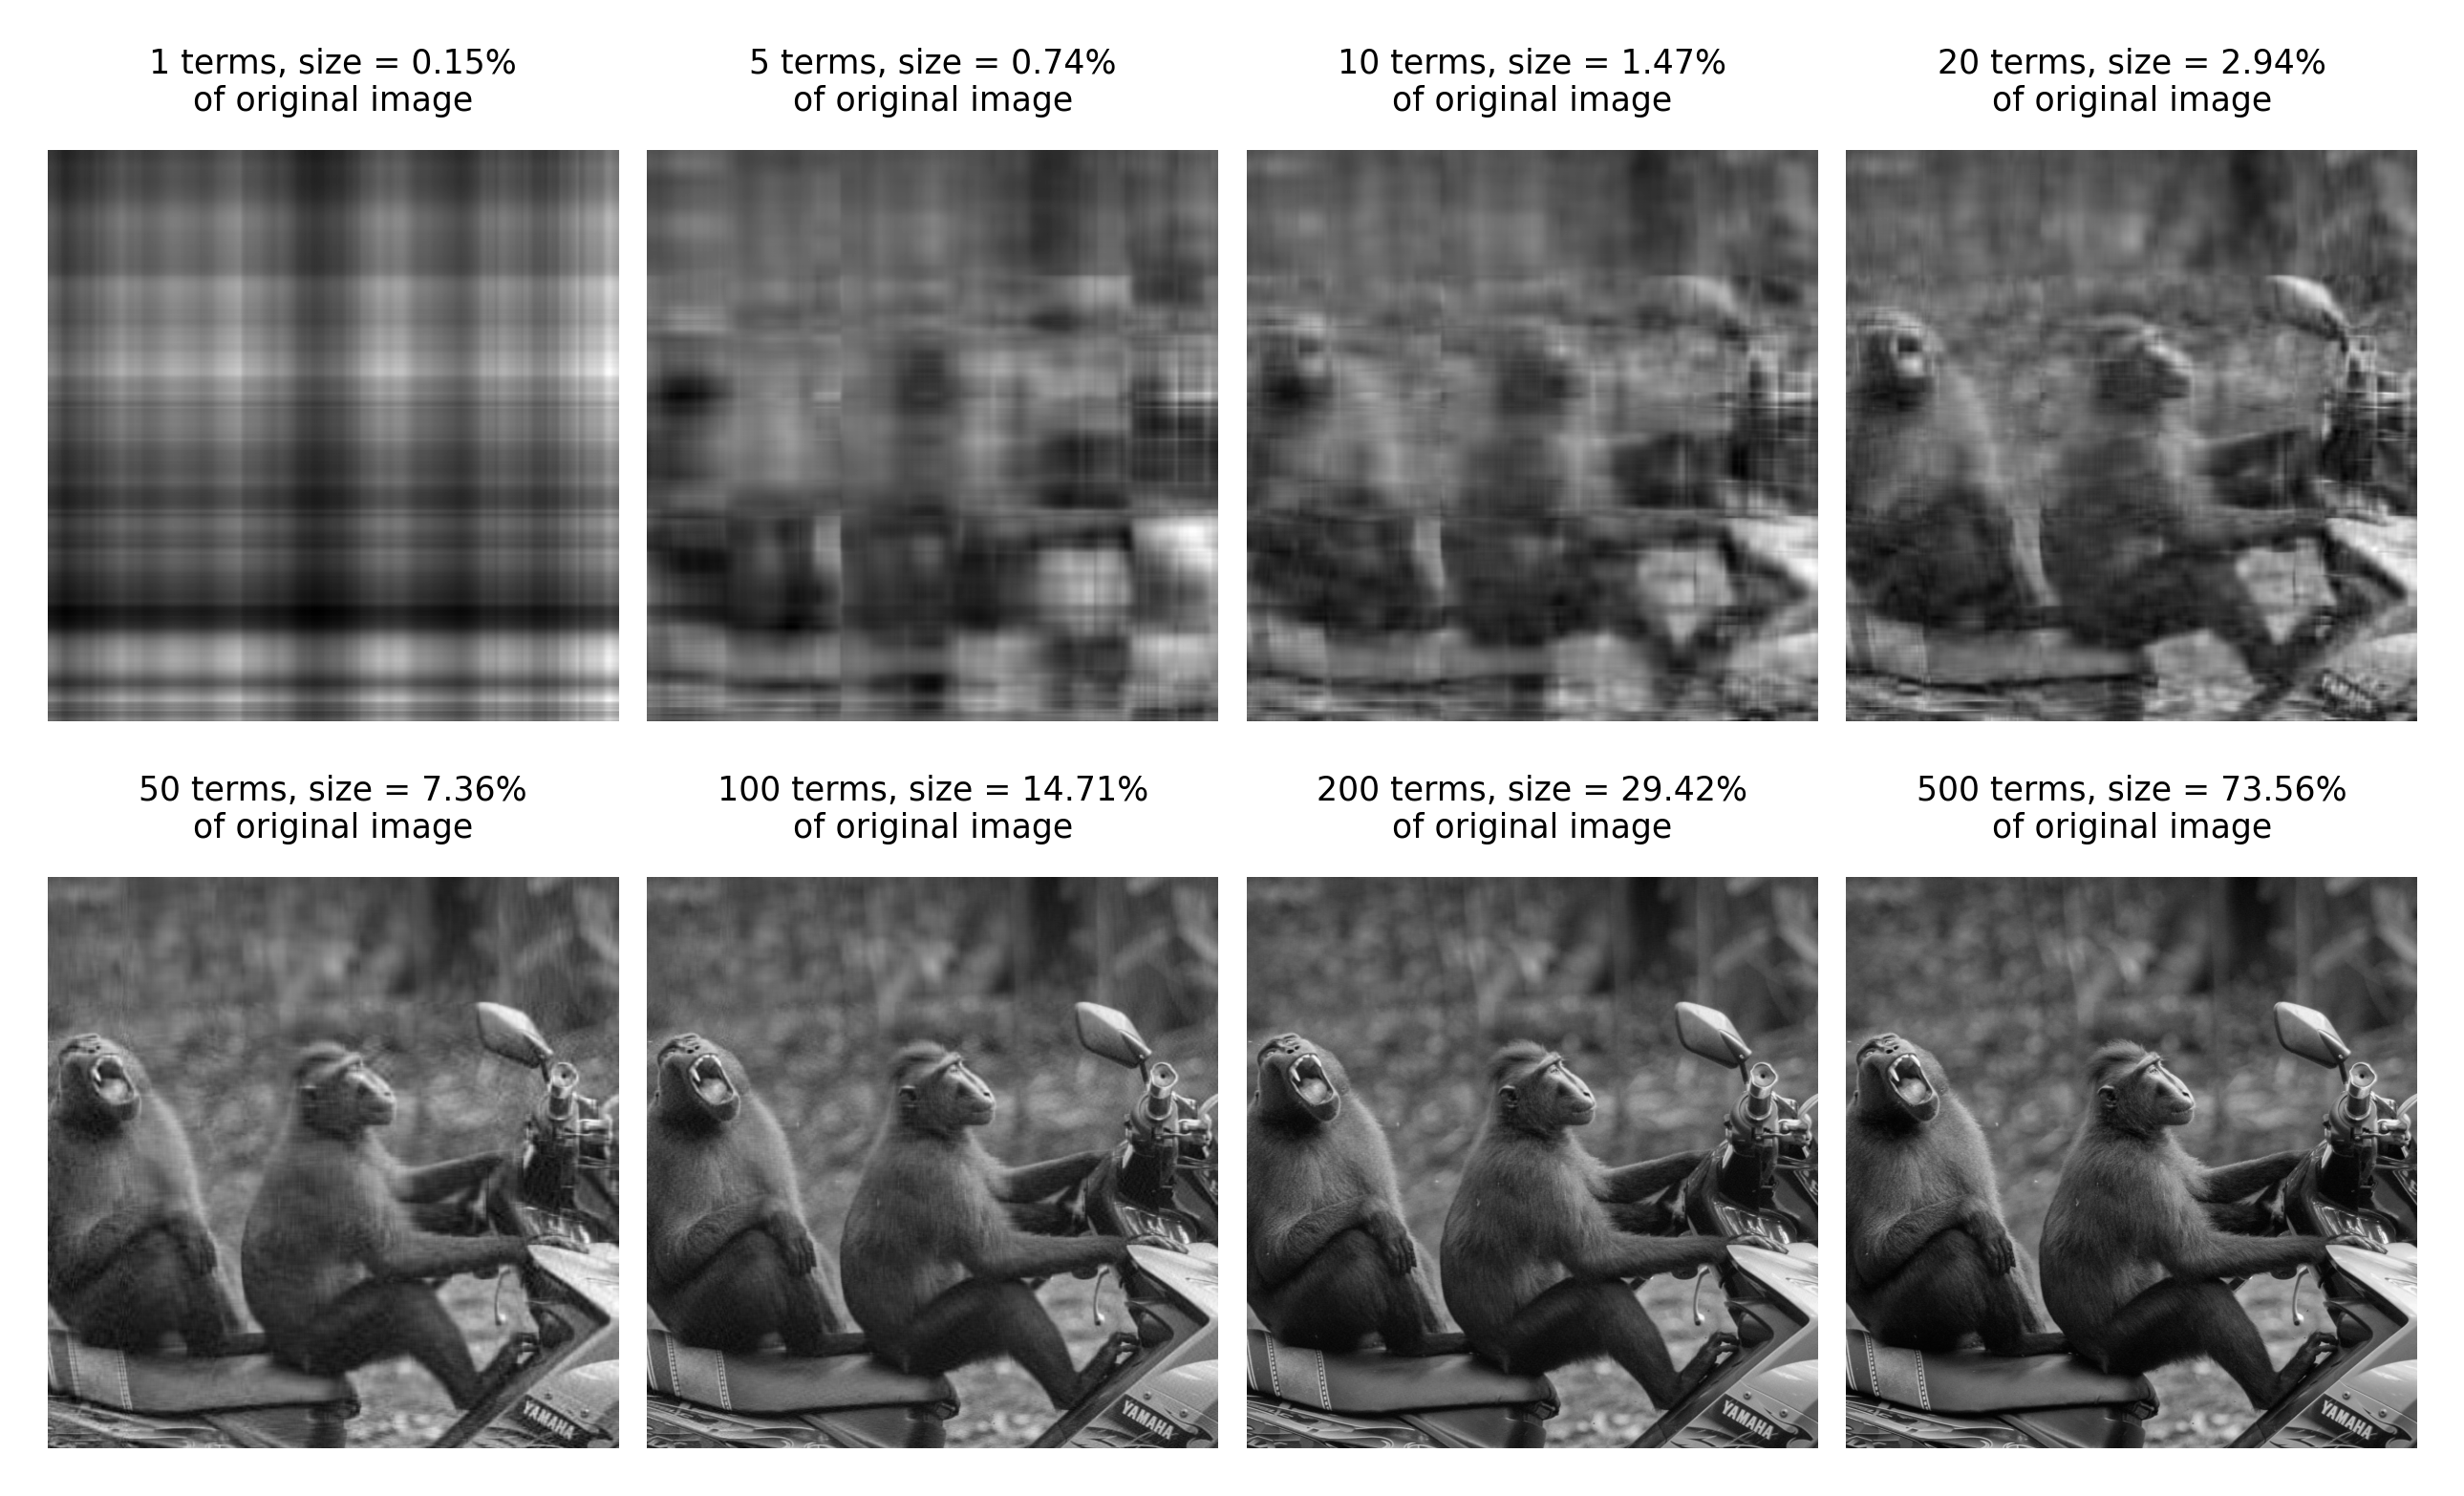

In [2]:
pic = "monkey"  # square
# pic = "lion"  # rectangle

print("creating image object")
img = GrayscaleImageSVD(f"static/{pic}.jpg")

print("reducing image")
A = []
comp = []
errors = []
terms = [1, 5, 10, 20, 50, 100, 200, 500]
places = 2
for n_terms in terms:
    A2, ratio, error = img.reduce(terms = n_terms)
    comp.append(round(ratio, places))
    errors.append(round(error, places))
    A.append(A2)

fig = plt.figure(dpi = 500)
gs = fig.add_gridspec(
	2,
	4,
	wspace=0.05,
	hspace=-0.3  # hspace=0.2 for lion and -0.3 for monkey
)

axs = gs.subplots(sharex=True, sharey=True)

for i in range(8):
    axs.flat[i].imshow(A[i], cmap='gray')
    axs.flat[i].axis("off")
    axs.flat[i].set_title(f"{terms[i]} terms, size = {comp[i]}%\nof original image", fontsize = 5)

plt.savefig(f"static/{pic}_evolution.png", bbox_inches='tight')
plt.show()

# Color image reduction comparison

In [3]:
pic = "crab"

print("creating image object")
img = ColourImageSVD(f"static/{pic}.jpg")

print("reducing image")
A = []
comp = []
errors = []
terms = [1, 5, 10, 20, 50, 100, 200, 500]
places = 2
for n_terms in terms:
    A2, ratio, error = img.reduce(terms = n_terms)
    comp.append(round(ratio, places))
    errors.append(round(error, places))
    A.append(A2)

fig = plt.figure(dpi = 500)
gs = fig.add_gridspec(2, 4, wspace=0.05, hspace=-0.55)
axs = gs.subplots(sharex=True, sharey=True)

for i in range(8):
    axs.flat[i].imshow(A[i], cmap='gray')
    axs.flat[i].axis("off")
    axs.flat[i].set_title(f"{terms[i]} terms, size = {comp[i]}%\nof original image", fontsize = 5)

plt.savefig(f"static/{pic}_evolution.png", bbox_inches='tight')
plt.show()

creating image object
SVD for Red Channel
SVD for Green Channel
SVD for Blue Channel
reducing image


TypeError: type list doesn't define __round__ method

# Calculating Error

In [ ]:
pic = "monkey"  # square
# pic = "lion"  # rectangle

print("creating image object")
img = GrayscaleImageSVD(f"static/{pic}.jpg")

print("reducing image")
errors = []
terms = np.arange(0, 600)
for n_terms in tqdm(terms):
    A2, ratio, error = img.reduce(terms = n_terms)
    errors.append(error)

In [ ]:
plt.plot(terms, errors)
plt.xlabel("Number of terms")
plt.ylabel(r"% RMS Error")

In [ ]:
pic = "crab"

print("creating image object")
img = ColourImageSVD(f"static/{pic}.jpg")

print("reducing image")
errors = []
eRs, eGs, eBs, average = [], [], [], []
terms = np.arange(0, 640, 5)
for n_terms in tqdm(terms):
    A2, ratio, [eR, eG, eB] = img.reduce(terms = n_terms)
    eRs.append(eR)
    eGs.append(eG)
    eBs.append(eB)
    average.append(eR + eG + eB)
eRs = np.array(eRs)
eGs = np.array(eGs)
eBs = np.array(eBs)
average = np.array(average)

In [ ]:
plt.plot(terms, eRs, "#ff0000", label = "Red Channel", alpha=0.5)
plt.plot(terms, eGs, "#00ff00", label = "Green Channel", alpha=0.5)
plt.plot(terms, eBs, "#0000ff", label = "Blue Channel", alpha=0.5)
plt.plot(terms, average/3, "#000000", label = "Average")
plt.xlabel("Number of terms")
plt.ylabel(r"% RMS Error")
plt.legend()